# Classification example

On Iris dataset

In [1]:
import random
import numpy as np
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
%matplotlib inline

from pycgp.mutation import probabilistic_mutation
from pycgp.evolution import evolution
from pycgp.benchmarks.classification import PARAMS, EV_PARAMS
from pycgp import Params, EvParams
from pycgp.visualize import to_graph
from pycgp.counter import Counter

Import IRIS data

In [2]:
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Function for custom onehot encoding

In [3]:
# custom onehot encoding
def encode(target_vector):
    oh_encoded_vectors = []
    for label in target_vector:
        vec = [0]*4
        vec[label] = 1
        oh_encoded_vectors.append(vec)
    return oh_encoded_vectors


def decode_label(vec):
    try:
        return vec.index(1)
    except ValueError:
        return 0
    
y_train_oh = encode(y_train)


In [4]:
from scipy.special import expit

def decode_to_target(y):
    y = np.array(y)
    y[y == None] = 1
    y = y.astype(int)
    labels = np.round(expit(y))
    int_labels = []
    for label in labels:
        int_labels.append(decode_label(label.tolist()))
    return int_labels

def cost_function(y_true, y):
    int_labels = decode_to_target(y)
        
    return -accuracy_score(int_labels, y_true)


In [5]:
%%time
random.seed(1)

params = Params(n_inputs=4, n_outputs=4, n_columns=50, funset=PARAMS['funset'])
ev_params = EvParams(cost_function, target_fitness=-1, max_evaluations=20000, mutation=probabilistic_mutation)

result = evolution(params, ev_params, X_train, y_train)

CPU times: user 1min 13s, sys: 781 ms, total: 1min 14s
Wall time: 1min 16s


Pick the best individual

In [6]:
best = result['stats']['best']
print('Train error: {:.4f}'.format(-best.fitness))

Train error: 0.9619


Show best individual and export image of graph into separate file.

In [7]:
for ind_str in str(best).split('|'):
    print(ind_str)
to_graph(best, 'iris-classification')

mul(pdiv(pdiv(x1,x2),x0),x0)|add(mul(x0,cos(plog(x2))),plog(x1))|x2|add(plog(plog(x1)),plog(x1))


Accuracy of best individual on test dataset

Test error: 0.9556


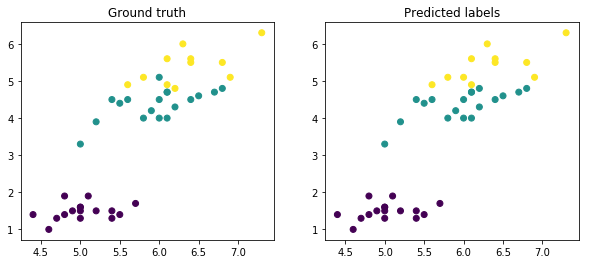

In [8]:
predicted_labels = decode_to_target(best.execute(X_test))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.scatter(X_test[:,0], X_test[:,2], c=y_test)
ax1.set_title('Ground truth')
ax2.scatter(X_test[:,0], X_test[:,2], c=predicted_labels)
ax2.set_title('Predicted labels')
print('Test error: {:.4f}'.format(-cost_function(y_test, best.execute(X_test))))
# the same:
#print('Test error: {:.4f}'.format(accuracy_score(y_test, predicted_labels)))

Mean fitness and best fitness of population from each generation during evolution.

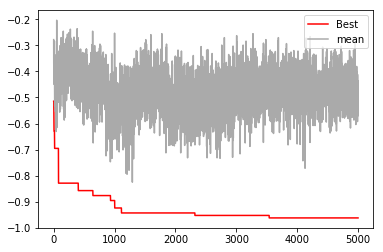

In [9]:
plt.plot([x.fitness for x in result['stats']['best_of_generation']], c='red', label='Best')
plt.plot(result['stats']['mean_of_generation'], c='#aaaaaa', label='mean')
plt.legend()

# Visualization of best individuals during evolution

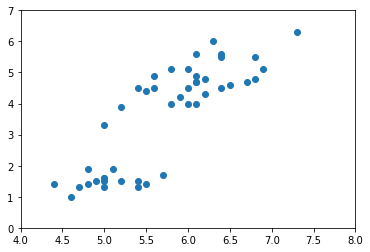

In [12]:
import numpy as np

import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML

from pycgp.counter import Counter

fig, ax = plt.subplots()

ax.set_xlim((4,8))
ax.set_ylim((0,7))

scat = ax.scatter(X_test[:,0], X_test[:, 2])

def get_colors(vec):
    colors = []
    for label in vec:
        if label == 0:
            colors.append('green')
        if label == 1:
            colors.append('blue')
        if label == 2:
            colors.append('red')
    return colors

def init():
    return scat,

def animate(i):
    ind = result['stats']['best_of_generation'][i]
    labels = decode_to_target(ind.execute(X_test))
    ax.set_title('generation {}, fitness: {:2f}'.format(i, ind.fitness))
    scat.set_color(get_colors(labels))
    return scat,

n_frames = len(result['stats']['mean_of_generation'])

symanim = animation.FuncAnimation(fig, animate, init_func=init, frames=n_frames, interval=5, blit=True)


In [13]:
%%time
HTML(symanim.to_html5_video())

CPU times: user 8min 24s, sys: 4min 50s, total: 13min 15s
Wall time: 4min 40s


In [17]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=25, bitrate=1800)
symanim.save('classification evolution.mp4', writer=writer)